# Miscellaneous Algorithms

Topics:
* Lyapunov exponent from numerical data
* Broomhead-King coordinates
* Finding fixed points of any map of any order
* Detecting chaos with GALI
* Docstrings


*warning: things will get really fast here*

---

# Lyapunov exponent from numerical data
It is possible to compute a maximum Lyapunov exponent from numerical data, stored either as a `Dataset` or as a `Reconstruction`. This is done with the function:

```julia
E = numericallyapunov(R::AbstractDataset, ks; kwargs...)
```
It returns `E = [E(k) for k ∈ ks]`, where `E(k)` is the average logarithmic distance 
between states of a `neighborhood` for `k` steps (`k` must be integer).

**For a more detailed description, please see the [documentation page](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/nlts/#numerical-lyapunov-exponent).**



In [25]:
using DynamicalSystems

Let's compute the lyapunov exponent for reference and compare our numerically calculated lyapunov exponent to it!

In [26]:
ds = Systems.henon()
λ = lyapunov(ds, 100000)

0.4201813067614222

Below we create a trajectory, produce a `Reconstruction`, and then pass that `Reconstruction` to `numericallyapunov`:

In [27]:
data = trajectory(ds, 1000000)
x = data[:, 1] #fake measurements for the win!

R = Reconstruction(x, 2, 2)
ks = 1:20
E = numericallyapunov(R, ks)

20-element Array{Float64,1}:
 -11.4419 
 -11.0439 
 -10.6137 
 -10.1945 
  -9.77516
  -9.35575
  -8.93631
  -8.5169 
  -8.09763
  -7.67824
  -7.25875
  -6.83934
  -6.41991
  -6.00054
  -5.58142
  -5.16226
  -4.74365
  -4.32636
  -3.91221
  -3.5058 

If the data experiences exponential separation of nearby states, then it must hold that

$$
E(k) \approx \lambda\times(k \Delta \! t ) + E(0)
$$

where $\Delta \! t$ is the time difference between successive data points (which is 1 for discrete systems).

*This means that, $\lambda$, the slope of the plot E vs. k, is our numerically determined lyapunov exponent.*

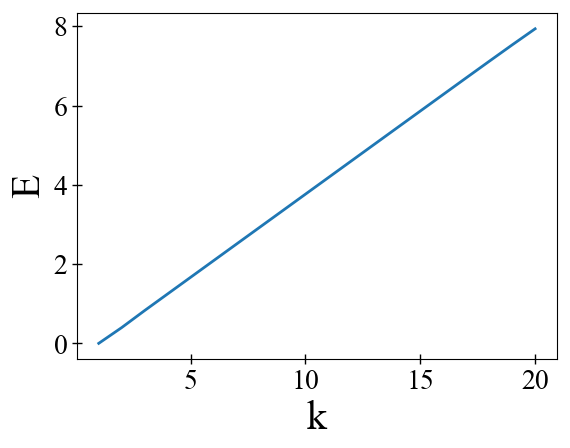

In [28]:
using PyPlot
figure(figsize=(6,4))
plot(ks, E .- E[1])
xlabel("k"); ylabel("E");

Above we see that the scaling behavior holds very nicely!

We can use linear_regions to compute the slope automatically:

In [29]:
λ_numeric = linear_region(ks, E)[2]

0.4188998139570098

In [30]:
println("λ - λ_numeric = $(abs(λ - λ_numeric))")

λ - λ_numeric = 0.0012814928044123652


`numericallyapunov` also takes a number of keyword arguments. You can decide:

1. Which states of the data should be used for reference states (by default *all* states are used).
2. How this logarithmic distance should be computed.
3. What type of `neighborhood` to use: fixed mass or fixed size.

# Broomhead-King coordinates

This alternative/improvement of the traditional delay coordinates `Reconstruction` can be a very powerful tool. An example where it shines is on noisy data where that noise creates the effect of superficial dimensions.

To show this, we'll use `Distributions` to create random numbers.

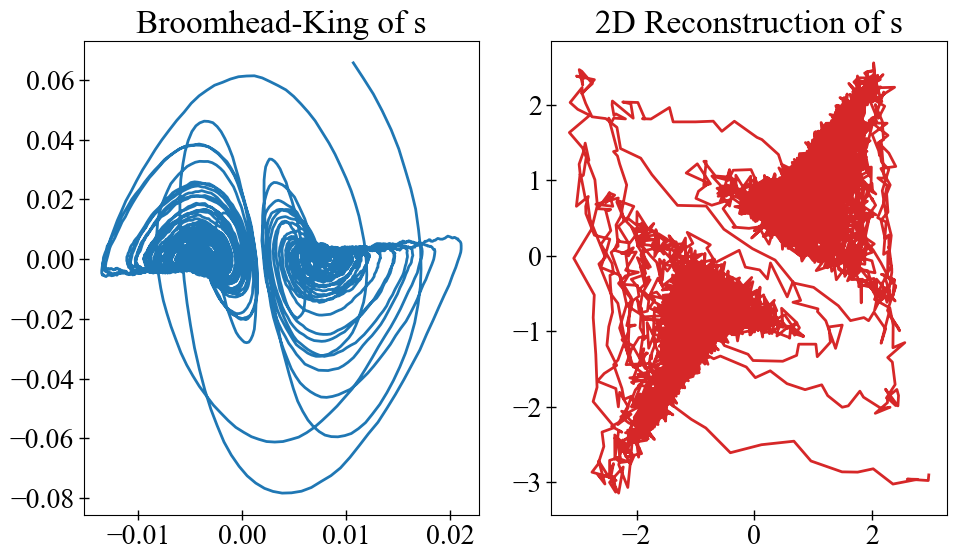

In [7]:
using Distributions

ds = Systems.gissinger()
data = trajectory(ds, 1000.0, dt = 0.05)
x = data[:, 1]

L = length(x)
distrib = Normal(0, 0.1)
s = x .+ rand(distrib, L)

U, S = broomhead_king(s, 40)

figure(figsize= (10,6))
subplot(1,2,1)
plot(U[:, 1], U[:, 2])
title("Broomhead-King of s")

subplot(1,2,2)
R = Reconstruction(s, 2, 30)
plot(columns(R)...; color = "C3")
title("2D Reconstruction of s")

tight_layout();

# Finding fixed points of maps
Finding unstable (or stable) periodic orbits of a discrete mapping analytically rapidly becomes impossible for higher orders of fixed points. Fortunately there is an algorithm from Schmelcher & Diakonos for doing so numerically. 

The function that performs the algorithm is:
```julia
periodicorbits(ds::DiscreteDynamicalSystem, o, ics, args..)
```
where `o` is the order of fixed points to find and `ics` are the initial conditions to start searching from.

This function can take a lot extra optional and keyword arguments and thus it is good practice to read the [documentation page](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/periodicity/#detecting-stable-and-unstable-periodic-orbits-of-maps) on it!!!

I will now compute fixed points of order 3 & 4 of the standard map:

In [8]:
ds = Systems.standardmap()

2-dimensional discrete dynamical system
 state:     [0.000228603, 0.000473075]
 e.o.m.:    DynamicalSystemsBase.Systems.standardmap_eom
 in-place?  false
 jacobian:  DynamicalSystemsBase.Systems.standardmap_jacob


In [9]:
xs = linspace(0, 2π, 21); ys = copy(xs)
ics = [SVector{2}(x,y) for x in xs for y in ys] # initial conditions container

441-element Array{StaticArrays.SArray{Tuple{2},Float64,1,2},1}:
 [0.0, 0.0]        
 [0.0, 0.314159]   
 [0.0, 0.628319]   
 [0.0, 0.942478]   
 [0.0, 1.25664]    
 [0.0, 1.5708]     
 [0.0, 1.88496]    
 [0.0, 2.19911]    
 [0.0, 2.51327]    
 [0.0, 2.82743]    
 [0.0, 3.14159]    
 [0.0, 3.45575]    
 [0.0, 3.76991]    
 ⋮                 
 [6.28319, 2.82743]
 [6.28319, 3.14159]
 [6.28319, 3.45575]
 [6.28319, 3.76991]
 [6.28319, 4.08407]
 [6.28319, 4.39823]
 [6.28319, 4.71239]
 [6.28319, 5.02655]
 [6.28319, 5.34071]
 [6.28319, 5.65487]
 [6.28319, 5.96903]
 [6.28319, 6.28319]

In [10]:
FP3 = periodicorbits(ds, 3, ics) # order 3 periodic points

2-dimensional Dataset{Float64} with 7 points
 0.0     0.0   
 0.8121  1.6243
 0.8121  3.9537
 3.1416  2.3295
 3.1416  3.9537
 5.471   2.3295
 5.471   4.6589


In [11]:
FP4 = periodicorbits(ds, 4, ics) # order 4 periodic points

2-dimensional Dataset{Float64} with 5 points
 0.0     0.0   
 0.0     3.1416
 3.1416  0.0   
 3.1416  3.1416
 3.1416  6.2832


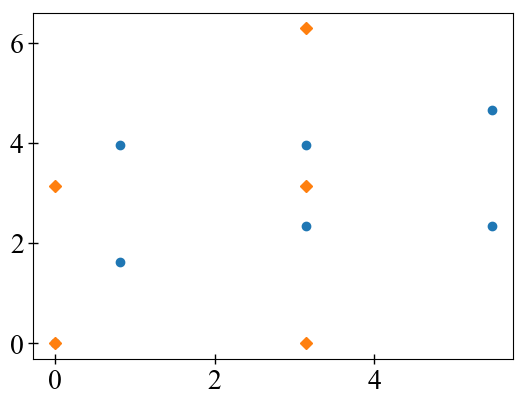

In [12]:
figure(figsize = (6,4))

plot([s[1] for s in FP3], [s[2] for s in FP3], marker = "o", color = "C0", ls = "None")
plot([s[1] for s in FP4], [s[2] for s in FP4], marker = "D", color = "C1", ls = "None");

Weeeeeeell this isn't really helpful as it doesn't show the phase-space of the standard map...

Let's start by creating the phasespace plot and then overlaying these points!

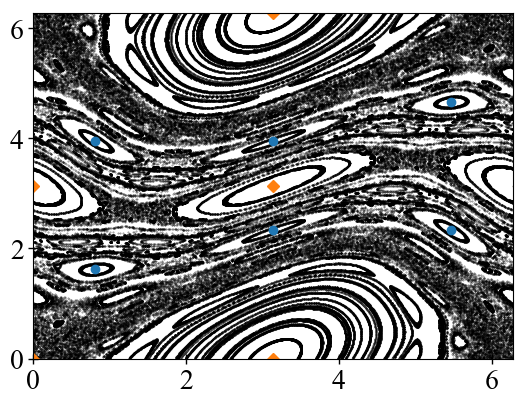

In [13]:
iters = 500
dataset = trajectory(ds, iters)
for x in xs
    for y in ys
        append!(dataset, trajectory(ds, iters, SVector{2}(x, y)))
    end
end

# plot phasespace
figure(figsize = (6,4))
plot(dataset[:, 1], dataset[:, 2], ls = "None", ms= 0.8, marker = ".", color = "black", alpha = 0.5)
xlim(xs[1], xs[end])
ylim(ys[1], ys[end])

# plot fixed points
plot([s[1] for s in FP3], [s[2] for s in FP3], marker = "o", color = "C0", ls = "None")
plot([s[1] for s in FP4], [s[2] for s in FP4], marker = "D", color = "C1", ls = "None");

* The function did **not** find all fixed points of order 3 or 4. 
* This happened because we did not set the other arguments of `periodicorbits`, and therefore a random value was chosen for them.

For more, I am pointing you to the [documentation example](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/periodicity/#standard-map-example), where the following picture is computed:

<img src="standardmap_fp.png" alt="Fixed points of the standard map" style="width: 800px;" align="left"/>


# Detecting Chaos using `gali`
* In (for example) Hamiltonian systems, it is quite often the case that regular orbits (i.e. periodic) co-exist with chaotic orbits.
* Being able to detect and distinguish chaotic from regular behavior is crucial in the study of dynamical systems. 
* Lyapunov exponents *can* be used for this task but they are not efficient.

* One of the newest methods to do this is "GALI", generalized alignment index method.

* GALI uses the fact that deviation vectors (that live on tangent space) tend to align for chaotic motion, while they stay "not-aligned" for regular motion.

---
Here I will only show a simple example of the standard map, which is a system with **mixed phase space**. 

For *regular* orbits, `gali` stays approximately constant. For *chaotic* orbits, `gali` decays exponentially.

We'll initialize with a random chaotic initial condition,

In [14]:
sm = Systems.standardmap(;k = 1.0)

2-dimensional discrete dynamical system
 state:     [0.000756496, 0.000410893]
 e.o.m.:    DynamicalSystemsBase.Systems.standardmap_eom
 in-place?  false
 jacobian:  DynamicalSystemsBase.Systems.standardmap_jacob


get a trajectory,

In [15]:
tr = trajectory(sm, 10000)

2-dimensional Dataset{Float64} with 10001 points
 0.000756496  0.000410893
 0.00192389   0.00116739 
 0.00501516   0.00309127 
 0.0131216    0.00810641 
 0.0343492    0.0212276  
 0.0899192    0.05557    
 0.235287     0.145368   
 0.613778     0.37849    
 1.56823      0.95445    
 3.52268      1.95445    
 5.1052       1.58252    
 5.76388      0.658684   
 5.92629      0.162407   
 ⋮                       
 4.95434      5.59506    
 3.29533      4.62418    
 1.48319      4.47105    
 0.667222     5.46721    
 0.470055     6.08602    
 0.725823     0.255768   
 1.64534      0.91952    
 3.56209      1.91674    
 5.07062      1.50853    
 5.64263      0.572013   
 5.617        6.25756    
 4.97338      5.63957    


and then plot it:

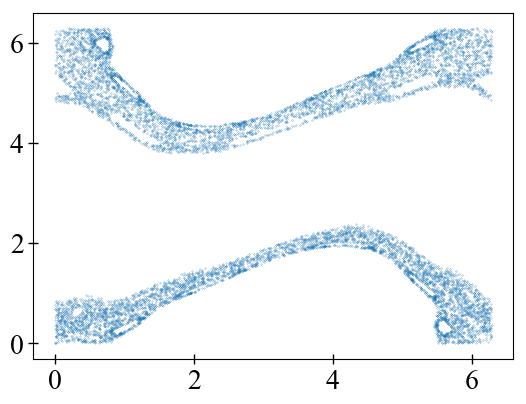

In [16]:
using PyPlot; figure(figsize=(6,4))
plot(tr[:, 1], tr[:, 2], ls = "None", marker = "o", ms = 0.2);

To compute `gali`, I use the following call signature:
```
gali(ds::DynamicalSystem, tfinal, k::Int; kwargs...) -> g, t
```
where `k` is the order of GALI I want and `tfinal` specifies for how much time to evolve the system and the deviation vectors.

Let's compute the gali_2 for this trajectory:

In [17]:
g, t = gali(sm, 1000, 2)
g

53-element Array{Float64,1}:
 1.0        
 0.390728   
 0.0605283  
 0.0088436  
 0.00129098 
 0.000189035
 2.82722e-5 
 4.8901e-6  
 2.28502e-6 
 5.135e-6   
 1.70036e-5 
 1.34234e-5 
 2.27326e-6 
 ⋮          
 3.42702e-10
 1.69526e-9 
 3.54202e-9 
 7.54277e-10
 1.25725e-10
 3.96006e-11
 9.6714e-11 
 2.36554e-10
 1.43357e-10
 2.30099e-11
 3.41216e-12
 5.18141e-13

* `g` quickly decays to zero for a chaotic orbit!

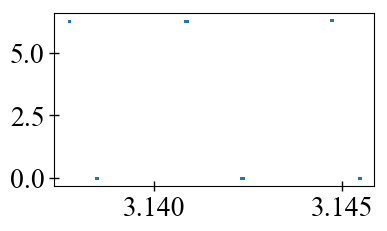

In [18]:
# Initialize with random regular initial condition:
sm = Systems.standardmap([π + 0.01*rand(), 0.01*rand()];k = 1.0)
# Get trajectory:
tr = trajectory(sm, 10000)
# Plot it:
using PyPlot; figure(figsize=(4,2))
plot(tr[:, 1], tr[:, 2], ls = "None", marker = "o", ms = 0.2);

In [19]:
# gali with regular initial condition:
g, t = gali(sm, 1000, 2)
g

1001-element Array{Float64,1}:
 1.0     
 0.933532
 0.682661
 1.0     
 0.933537
 0.682664
 1.0     
 0.933542
 0.682666
 1.0     
 0.933547
 0.682668
 1.0     
 ⋮       
 0.683392
 1.0     
 0.935167
 0.683395
 1.0     
 0.935172
 0.683397
 1.0     
 0.935177
 0.683399
 1.0     
 0.935182

* `g` stays constant for a regular orbit!

# Docstrings

In [20]:
?numericallyapunov

search: numericallyapunov



```
numericallyapunov(R::AbstractDataset, ks;  refstates, w, distance, ntype)
```

Return `E = [E(k) for k ∈ ks]`, where `E(k)` is the average logarithmic distance between states of a [`neighborhood`](@ref) that are evolved in time for `k` steps (`k` must be integer).

## Keyword Arguments

  * `refstates = 1:(length(R) - ks[end])` : Vector of indices that notes which states of the reconstruction should be used as "reference states", which means that the algorithm is applied for all state indices contained in `refstates`.
  * `w::Int = round(Int, mean(R.delay))` : The Theiler window, which determines whether points are separated enough in time to be considered separate trajectories (see [1]). Defaults to the mean delay time. If you give a `Dataset` instead of a `Reconstruction` in the place of `R`, you *must* provide the Theiler window (you can give `w=typemax(Int)` if it does not apply to your case).
  * `ntype::AbstractNeighborhood = FixedMassNeighborhood(1)` : The method to be used when evaluating the neighborhood of each reference state. See [`AbstractNeighborhood`](@ref) or [`neighborhood`](@ref) for more info.
  * `distance::Metric = Cityblock()` : The distance function used in the logarithmic distance of nearby states. The allowed distances are `Cityblock()` and `Euclidean()`. See below for more info.

## Description

If the dataset/reconstruction exhibits exponential divergence of nearby states, then it should clearly hold

$$
E(k) \approx \lambda\Delta t k + E(0)
$$

for a *well defined region* in the `k` axis, where $\lambda$ is the approximated maximum Lyapunov exponent. $\Delta t$ is the time between samples in the original timeseries. You can use [`linear_region`](@ref) with arguments `(ks .* Δt, E)` to identify the slope (= $\lambda$) immediatelly, assuming you have choosen sufficiently good `ks` such that the linear scaling region is bigger than the saturated region.

The algorithm used in this function is due to Parlitz [1], which itself expands upon Kantz [2]. In sort, for each reference state a neighborhood is evaluated. Then, for each point in this neighborhood, the logarithmic distance between reference state and neighborhood state is calculated as the "time" index `k` increases. The average of the above over all neighborhood states over all reference states is the returned result.

If the `Metric` is `Euclidean()` then use the Euclidean distance of the full `D`-dimensional points (distance $d_E$ in ref. [1]). If however the `Metric` is `Cityblock()`, calculate the absolute distance of *only the first elements* of the `m+k` and `n+k` points of the reconstruction `R`(distance $d_F$ in ref. [1]).

## References

[1] : Skokos, C. H. *et al.*, *Chaos Detection and Predictability* - Chapter 1 (section 1.3.2), Lecture Notes in Physics **915**, Springer (2016)

[2] : Kantz, H., Phys. Lett. A **185**, pp 77–87 (1994)


In [21]:
?broomhead_king

search: broomhead_king



```
broomhead_king(s::AbstractVector, d::Int) -> U, S, Vtr
```

Return the Broomhead-King coordinates of a timeseries `s` by performing `svd` on the so-called trajectory matrix with dimension `d`.

## Description

Broomhead and King coordinates is an approach proposed in [1] that applies the Karhunen–Loève theorem to delay coordinates embedding with smallest possible delay.

The function performs singular value decomposition on the `d`-dimensional trajectory matrix $X$ of $s$,

$$
X = \frac{1}{\sqrt{N}}\left(
\begin{array}{cccc}
x_1 & x_2 & \ldots & x_d \\
x_2 & x_3 & \ldots & x_{d+1}\\
\vdots & \vdots & \vdots & \vdots \\
x_{N-d+1} & x_{N-d+2} &\ldots & x_N
\end{array}
\right) = U\cdot S \cdot V^{tr}.
$$

where $x := s - \bar{s}$. The columns of $U$ can then be used as a new coordinate system, and by considering the values of the singular values $S$ you can decide how many columns of $U$ are "important". See the documentation page for example application.

## References

[1] :  D. S. Broomhead, R. Jones and G. P. King, J. Phys. A **20**, 9, pp L563 (1987)


In [22]:
?periodicorbits

search: periodicorbits



```
periodicorbits(ds::DiscreteDynamicalSystem, o, ics [, λs, indss, singss]; kwargs...) -> FP
```

Find fixed points `FP` of order `o` for the map `ds` using the algorithm due to Schmelcher & Diakonos [1]. `ics` is a collection of initial conditions (container of vectors) to be evolved.

## Optional Arguments

The optional arguments `λs, indss, singss` *must be containers* of appropriate values, besides `λs` which can also be a number. The elements of those containers are passed to: `lambdamatrix(λ, inds, sings)`, which creates the appropriate $\mathbf{\Lambda}_k$ matrix (see [`lambdamatrix`](@ref) for more). If these arguments are not given, a random permutation will be chosen for them, with `λ=0.001`.

## Keyword Arguments

  * `maxiters::Int = 100000` : Maximum amount of iterations an i.c. will be iterated  before claiming it has not converged.
  * `disttol = 1e-10` : Distance tolerance. If the 2-norm of a previous state with  the next one is `≤ disttol` then it has converged to a fixed point.
  * `inftol = 10.0` : If a state reaches `norm(state) ≥ inftol` it is assumed that  it has escaped to infinity (and is thus abandoned).
  * `roundtol::Int = 4` : The found fixed points are rounded  to `roundtol` digits before pushed into the list of returned fixed points `FP`,  *if* they are not already contained in `FP`.  This is done so that `FP` doesn't contain duplicate fixed points (notice  that this has nothing to do with `disttol`). Turn this to `typemax(Int)`  to get the full precision of the algorithm.

## Description

The algorithm used can detect periodic orbits by turning fixed points of the original map `ds` to stable ones, through the transformation

$$
\mathbf{x}_{n+1} = \mathbf{x}_n +
\mathbf{\Lambda}_k\left(f^{(o)}(\mathbf{x}_n) - \mathbf{x}_n\right)
$$

with $f$ = `eom`. The index $k$ counts the various possible $\mathbf{\Lambda}_k$.

## Performance Notes

*All* initial conditions are evolved for *all* $\mathbf{\Lambda}_k$ which can very quickly lead to long computation times.

## References

[1] : P. Schmelcher & F. K. Diakonos, Phys. Rev. Lett. **78**, pp 4733 (1997)


In [23]:
?lambdamatrix

search: lambdamatrix



```
lambdamatrix(λ, inds::Vector{Int}, sings) -> Λk
```

Return the matrix $\mathbf{\Lambda}_k$ used to create a new dynamical system with some unstable fixed points turned to stable in the function [`periodicorbits`](@ref).

## Arguments

1. `λ<:Real` : the multiplier of the $C_k$ matrix, with `0<λ<1`.
2. `inds::Vector{Int}` : The `i`th entry of this vector gives the *row* of the nonzero element of the `i`th column of $C_k$.
3. `sings::Vector{<:Real}` : The element of the `i`th column of $C_k$ is +1 if `signs[i] > 0` and -1 otherwise (`sings` can also be `Bool` vector).

Calling `lambdamatrix(λ, D::Int)` creates a random $\mathbf{\Lambda}_k$ by randomly generating an `inds` and a `signs` from all possible combinations. The *collections* of all these combinations can be obtained from the function [`lambdaperms`](@ref).

## Description

Each element of `inds` *must be unique* such that the resulting matrix is orthogonal and represents the group of special reflections and permutations.

Deciding the appropriate values for `λ, inds, sings` is not trivial. However, in ref. [2] there is a lot of information that can help with that decision. Also, by appropriately choosing various values for `λ`, one can sort periodic orbits from e.g. least unstable to most unstable, see [3] for details.

## References

[2] : D. Pingel *et al.*, Phys. Rev. E **62**, pp 2119 (2000)

[3] : F. K. Diakonos *et al.*, Phys. Rev. Lett. **81**, pp 4349 (1998)


In [24]:
?gali

search: gali generalized_dim GeneralizedPareto GeneralizedExtremeValue eigvals



```
gali(ds::DynamicalSystem, tmax, k::Int | Q0; kwargs...) -> GALI_k, t
```

Compute $\text{GALI}_k$ [1] for a given `k` up to time `tmax`. Return $\text{GALI}_k(t)$ and time vector $t$.

The third argument, which sets the order of `gali`, can be an integer `k`, or a matrix with its columns being the deviation vectors (then `k = size(Q0)[2]`). In the first case random orthonormal vectors are chosen.

## Keyword Arguments

  * `threshold = 1e-12` : If `GALI_k` falls below the `threshold` iteration is terminated.
  * `dt = 1` : Time-step between deviation vector normalizations. For continuous systems this is approximate.
  * `diff_eq_kwargs` : See [`trajectory`](@ref).
  * `u0` : Initial state for the system. Defaults to `get_state(ds)`.

## Description

The Generalized Alignment Index, $\text{GALI}_k$, is an efficient (and very fast) indicator of chaotic or regular behavior type in $D$-dimensional Hamiltonian systems ($D$ is number of variables). The *asymptotic* behavior of $\text{GALI}_k(t)$ depends critically on the type of orbit resulting from the initial condition. If it is a chaotic orbit, then

$$
\text{GALI}_k(t) \sim
\exp\left[\sum_{j=1}^k (\lambda_1 - \lambda_j)t \right]
$$

with $\lambda_j$ being the `j`-th Lyapunov exponent (see [`lyapunov`](@ref), [`lyapunovs`](@ref)). If on the other hand the orbit is regular, corresponding to movement in $d$-dimensional torus with $1 \le d \le D/2$ then it holds

$$
\text{GALI}_k(t) \sim
    \begin{cases}
      \text{const.}, & \text{if} \;\; 2 \le k \le d  \; \; \text{and}
      \; \;d > 1 \\
      t^{-(k - d)}, & \text{if} \;\;  d < k \le D - d \\
      t^{-(2k - D)}, & \text{if} \;\;  D - d < k \le D
    \end{cases}
$$

Traditionally, if $\text{GALI}_k(t)$ does not become less than the `threshold` until `tmax` the given orbit is said to be chaotic, otherwise it is regular.

Our implementation is not based on the original paper, but rather in the method described in [2], which uses the product of the singular values of $A$, a matrix that has as *columns* the deviation vectors.

## Performance Notes

This function uses a [`tangent_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

See the "advanced documentation" for info on the integrator object and use `@which ...` to go to the source code for the low-level call signature.

## References

[1] : Skokos, C. H. *et al.*, Physica D **231**, pp 30–54 (2007)

[2] : Skokos, C. H. *et al.*, *Chaos Detection and Predictability* - Chapter 5 (section 5.3.1 and ref. [85] therein), Lecture Notes in Physics **915**, Springer (2016)
